##  Transfer Learning Using Self-supervised Pretraining

- Flowers dataset https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


Mounting Google drive to Colab.
Only the directory path will be changed according to directory path in Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Installing required libraries and modules

Importing required libraries

In [2]:
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 16.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import pl_bolts
import torchvision
import torchmetrics
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

Point the data_dir to where your flowers dataset is loaded in Google Drive

Original images are not square and all of different sizes

In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/07_Self-Supervised Machine Learning/datasets/flower/flowers'

os.listdir(data_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

First of all images need to be of same size (resized to 224 x 224) and to be converted to Tensor form and normalized.

- Pre-trained models in Pytorch expect images to be at least 224 x 224 in size
- Images are also normalized using the mean and standard deviation of the Imagenet dataset which comprises of millions of images
- If you know the mean and standard deviation of your own image dataset you can use that to normalize images

Data module inherited from LightningDataModule:

A collection of a train_dataloaders, val_dataloaders, test_dataloaders along with the matching transforms and data processing/downloads steps required.

To define a DataModule define 5 methods:

1.prepare_data (how to download(), tokenize, etc…) (not implemented in this case)

2.setup (how to split, etc…)

3.train_dataloader

4.val_dataloader(s)

5.test_dataloader(s) (Not implemented in this case)

Agument the data to increase the number of samples used to fine-tune the pre-trained model on our data

Link for reference:

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html#what-is-a-datamodule

In [5]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, data_dir =  '/content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/07_Self-Supervised Machine Learning/datasets/flower/flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose(
          [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
              ),
          ]
        )

    def setup(self, stage= None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)

        length = len(flower_full)

        val_split_size = 0.2

        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length

        self.flower_train, self.flower_val = \
          random_split(flower_full , [train_length, val_length])

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


Flower Data module is instantiated and setup is called

In [6]:
flower_dm = FlowerDataModule()

flower_dm.setup()

Training and validation dataloaders are obtained and dimensions are checked. Note that len(dataloader) gives no. of batches as Dataloader loads images in batch form.

In [7]:
train_dl = flower_dm.train_dataloader()

len(train_dl)

109

In [8]:
valid_dl = flower_dm.val_dataloader()

len(valid_dl)

28

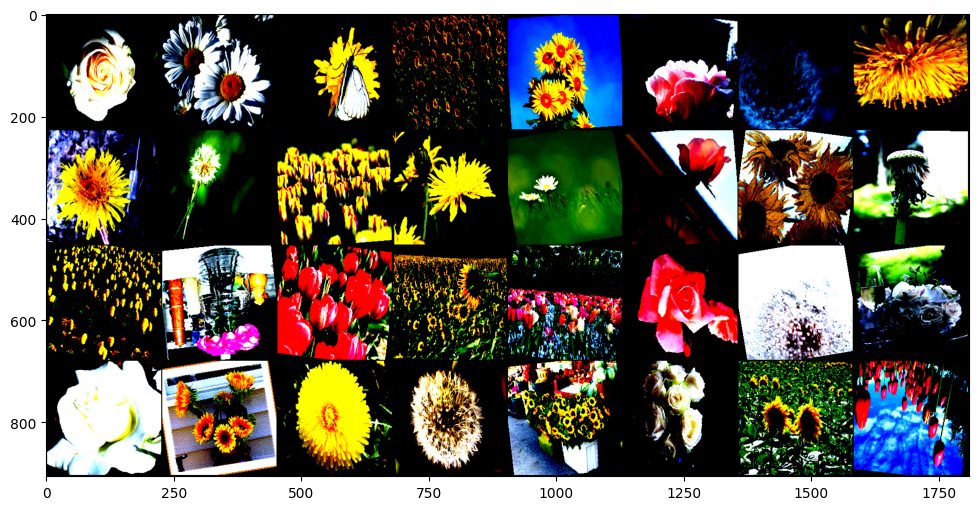

In [9]:
def show_batch_images(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch_images(train_dl)

## Self-Supervised Pretraining with SIMCLR
https://pytorch-lightning-bolts.readthedocs.io/en/latest/self_supervised_models.html#simclr

We use pretrained SimCLR model trained on imagenet data (self-supervised)

Note that here we are unfreezing our backbone after 10 epochs of training of model.

In [10]:
# Importing the SimCLR model from pytorch Lightening bolts
from pl_bolts.models.self_supervised import SimCLR

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        # Specify the weight path, where the model parameters are saved, it saved in a AWS S3 bucket
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'

        # load with checkpoint, strict = False --> if model keys that are not in state dictionary of the model
        # those will just ignore
        simclr = SimCLR.load_from_checkpoint(weight_path, strict = False)

        # SimCLR model set as backbone
        self.backbone = simclr

        # the dimensionality of the embeddings generated by this SimCLR is 2048
        # So our last layer, linear classifier or finetune layer will have
        # input dimensionality of 2048 output of our classes

        self.finetune_layer = torch.nn.Linear(2048, num_classes)

    # Training Step
    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
        else:
            features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=5)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch

        features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=5)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return metrics

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

CSV Logger is defined to log the metrics into a csv file

In [11]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'simclr_bb_unfrozen')

Classifier is called and Trainer is defined and fit with Flower Datamodule. Training is done for 20 epochs and logger is used for logging metrics

In [12]:
# classifier = FlowerImageClassifier()

# trainer = pl.Trainer(gpus = 1, max_epochs = 20, logger = logger)

# trainer.fit(classifier, flower_dm)

In [13]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20,
                     log_every_n_steps = 10, logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm)

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt
100%|██████████| 229M/229M [00:05<00:00, 43.4MB/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


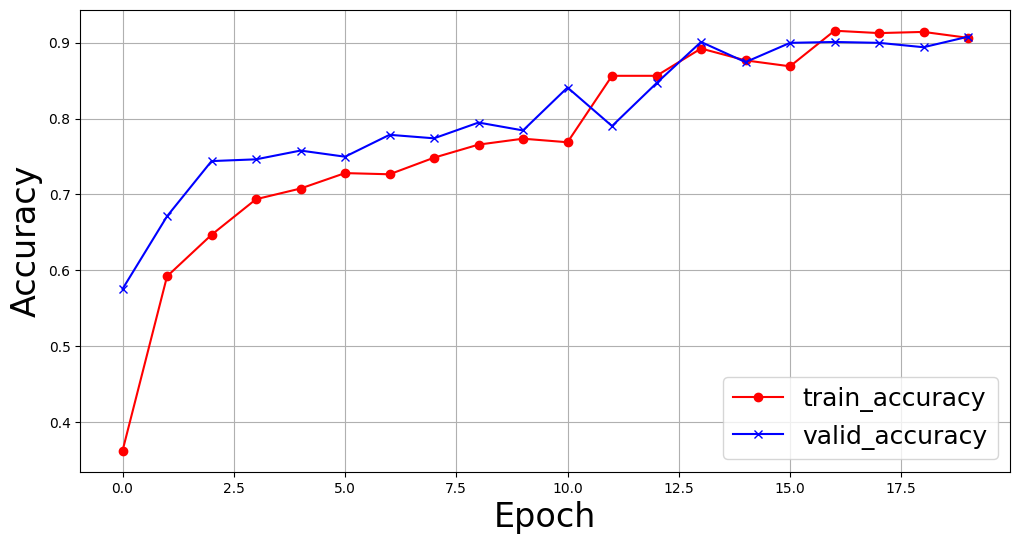

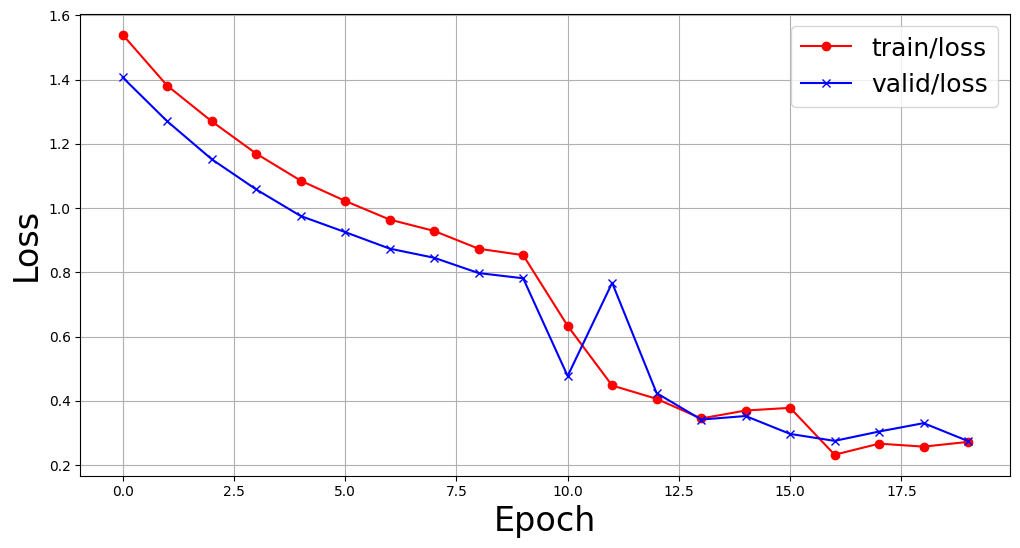

In [15]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_simclr.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_simclr.png')

In [ ]:
class ApplyTransform(Dataset):

    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

    def __len__(self):
        return len(self.dataset)

Transformations for both training and validation data specific to SIMCLR are defined here:

https://pytorch-lightning-bolts.readthedocs.io/en/latest/transforms.html#simclr-transforms

In [ ]:
from pl_bolts.models.self_supervised.simclr.transforms import SimCLRTrainDataTransform

train_transform = SimCLRTrainDataTransform(input_height = 224)

In [ ]:
#train_transform = SimCLRTrainDataTransform(input_height = 224, normalize = transforms.Normalize(
            #mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
        #))

In [ ]:
from pl_bolts.models.self_supervised.simclr.transforms import SimCLREvalDataTransform

val_transform = SimCLREvalDataTransform(input_height = 224)

In [ ]:
#val_transform = SimCLREvalDataTransform(input_height = 224, normalize = transforms.Normalize(
            #mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
        #))

Modified Datamodule is defined with transformations

In [ ]:
class FlowerDataModule(pl.LightningDataModule):

    def __init__(self, train_transform, val_transform, data_dir = '/content/drive/MyDrive/flower/flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose([torchvision.transforms.Resize((224, 224))])

        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage = None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)

        length = len(flower_full)

        val_split_size = 0.2

        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length

        self.flower_train, self.flower_val = \
          random_split(flower_full , [train_length, val_length])

        self.flower_train = ApplyTransform(self.flower_train, transform = self.train_transform)
        self.flower_val = ApplyTransform(self.flower_val, transform = self.val_transform)

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader

Datamodule is instantiated and setup called

In [ ]:
flower_dm_simclr = FlowerDataModule(train_transform, val_transform)

flower_dm_simclr.setup()

Training dataloader is obtained and dimension is checked. Note that len(dataloader) gives no. of batches as Dataloader loads images in batch form.

In [ ]:
train_dl = flower_dm_simclr.train_dataloader()

len(train_dl)

Displaying augmented images with those transformations. Three sets of Images are formed. We are showing first set.

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images[0], nrow = 8).permute(1, 2, 0))
        break

show_batch(train_dl)

Modified CLassifier Module with only one change where x=x[0]

In [ ]:
class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'

        simclr = SimCLR.load_from_checkpoint(weight_path, strict = False)

        self.backbone = simclr
        self.finetune_layer = torch.nn.Linear(2048, num_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x[0]

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
        else:
            features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x[0]

        features = self.backbone(x)
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return metrics

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

Model is trained in the same way as earlier with logging.

In [ ]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'simclr_bb_unfrozen_with_simclrtransform')

Validation accuracy after one epoch is 100%.

In [ ]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20,
                     limit_train_batches = 20,
                     log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm_simclr)

In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_simclr_tr.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_simclr_tr.png')\

![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")